## Time Series Prediction of IBM Stock Prices with a Simple RNN
This notebook aims to leverage the power of recurrent neural networks (RNNs) to predict the closing stock prices of IBM. We exploit the historical trends and patterns inherent in financial market data to build and train our RNN model, a task that recurrent networks are naturally suited for, given their ability to maintain a sort of "memory" of past information.

The dataset used for this analysis is publicly available on Kaggle and contains historical stock prices for IBM. It can be accessed through the following link: https://www.kaggle.com/datasets/bhanuprasanna527/stock-market-prediction. The data includes various attributes like 'Low', 'Open', 'Volume', 'High', 'Close', and 'Adjusted Close' recorded over several years. For the scope of this model, we will focus solely on the 'Close' column, which represents the closing price of the stock each day.

In [238]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import torch 
import numpy as np
import plotly
from torch import nn
from sklearn.model_selection import train_test_split

In [239]:
df = pd.read_csv('IBM.csv')
print(df)

             Date         Low        Open   Volume        High       Close  \
0      02-01-1970   17.399618   17.423517   330536   17.483271   17.435469   
1      05-01-1970   17.495220   17.495220   443504   17.602772   17.602772   
2      06-01-1970   17.507170   17.602772   510448   17.638622   17.614723   
3      07-01-1970   17.507170   17.614723   479068   17.626673   17.626673   
4      08-01-1970   17.566921   17.626673   740568   17.662523   17.662523   
...           ...         ...         ...      ...         ...         ...   
13351  06-12-2022  146.699997  147.300003  2847600  147.800003  147.500000   
13352  07-12-2022  146.289993  147.330002  3971300  148.100006  147.270004   
13353  08-12-2022  147.369995  147.899994  2665700  149.149994  147.779999   
13354  09-12-2022  146.970001  147.399994  3047600  148.339996  147.050003   
13355  12-12-2022  146.942596  147.820007  1049947  148.279999  147.589996   

       Adjusted Close  
0            4.003040  
1            4.

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13356 entries, 0 to 13355
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            13356 non-null  object 
 1   Low             13356 non-null  float64
 2   Open            13356 non-null  float64
 3   Volume          13356 non-null  int64  
 4   High            13356 non-null  float64
 5   Close           13356 non-null  float64
 6   Adjusted Close  13356 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 730.5+ KB


In [241]:
df['Date'] = pd.to_datetime(df['Date'])

/tmp/ipykernel_58776/2394721818.py:1: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [242]:
df.set_index('Date',inplace=True)

In [243]:
df.head()

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,
1970-02-01,17.399618,17.423517,330536,17.483271,17.435469,4.003040
1970-05-01,17.495220,17.495220,443504,17.602772,17.602772,4.041449
1970-06-01,17.507170,17.602772,510448,17.638622,17.614723,4.044193
1970-07-01,17.507170,17.614723,479068,17.626673,17.626673,4.046936
1970-08-01,17.566921,17.626673,740568,17.662523,17.662523,4.055170


In [244]:
df.tail()

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,
2022-06-12,146.699997,147.300003,2847600,147.800003,147.500000,147.500000
2022-07-12,146.289993,147.330002,3971300,148.100006,147.270004,147.270004
2022-08-12,147.369995,147.899994,2665700,149.149994,147.779999,147.779999
2022-09-12,146.970001,147.399994,3047600,148.339996,147.050003,147.050003
2022-12-12,146.942596,147.820007,1049947,148.279999,147.589996,147.589996


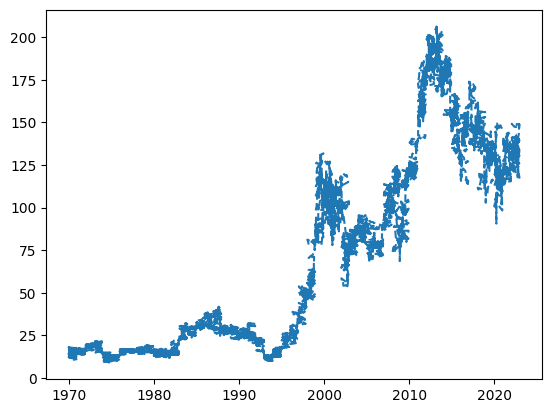

In [245]:
plt.plot(df['Close'], linestyle='--')
plt.show()

### Model Architecture
We use a simple RNN built using PyTorch. The model is structured with two main layers: an input-to-hidden layer (in_h) and an input-to-output layer (in_out). The hidden layer serves to compute the next hidden state, while the output layer computes the output.

The model follows a specific sequence: input and hidden states are concatenated and passed through the in_h layer, activated by the tanh function to compute the h_out. Next, an output is produced at each timestep using the in_out layer.

In [246]:
class VanillaRNN(nn.Module): 
    
    def __init__(self, len_in, len_h, len_out):
        super(VanillaRNN, self).__init__()
        self.len_h = len_h #size of hidden state
        self.in_h = nn.Linear(len_in + len_h, len_h) #graph module to compute next hidden state 
        self.in_out = nn.Linear(len_in + len_h, len_out) #computes output 
        self.tanh = nn.Tanh()

    def forward(self, x, h):
        #here we choose to concatenate the hidden state and input 
        #another approach would be to multiply these vectors 
        combined = torch.cat((x, h), 2) 
        h_out = self.tanh(self.in_h(combined)) 
        #we choose to produce an output at each timestep
        y = self.in_out(combined) 
        return y, h_out 

    def init_h(self, batch_size, sequence_length):
        #zero initialization 
        #alternatives include but not limited to Xavier/Kaiminh initialization
        return torch.zeros(batch_size, sequence_length, self.len_h, requires_grad=False)

## Training

In [247]:
def train(model, data_loader, loss_function, optim, epochs, device, scheduler, start_decay):
    
    losses = [] #group losses for loss visualization 
    
    for epoch in range(epochs):
        running_loss = 0 
        print("Epoch %d / %d" % (epoch+1, epochs))
        print("-"*10)
        if (epoch > start_decay): 
            scheduler.step()
    
        for i, (x, y) in enumerate(data_loader):
            h_s = model.init_h(x.shape[0], x.shape[1]).to(device) 
                
            x = x.to(device)
            y = y.to(device)
            y_pred, h_out = model(x, h_s)
            y_pred = y_pred[:, -1, :]
            h_s = h_out
            
            loss = loss_function(y_pred, y) 
            running_loss+=loss.item()
            
        
            optim.zero_grad()
            loss.backward() #backprop 
            optim.step() #update weights
  
        losses.append((running_loss / i))
        print("Step: {}/{}, current Epoch loss: {:.4f}".format(i, len(data_loader), (running_loss / i)))
        
    return losses

In [248]:
def load_data(stock, sequence_length):
    # Convert pandas dataframe to numpy array
    data_raw = stock.to_numpy()

    data = []

    # Loop over the stock data to generate sequences of 'sequence_length' consecutive data points
    # This is done because RNNs learn to predict data in a sequence from past sequence
    for index in range(len(data_raw) - sequence_length):
        data.append(data_raw[index: index + sequence_length])

    data = np.array(data)
    set_size = int(data.shape[0])

    # Generate the train data
    # x_train is all sequences excluding the last data point from each sequence
    x = data[:,:-1,:]
    # y_train is the last data point from each sequence
    y = data[:,-1,:]
    

    # Return the train and test data
    return [x, y]

In [249]:
ibm_df = pd.read_csv('IBM.csv')
ibm_df['Date'] = pd.to_datetime(ibm_df['Date'])
ibm_df.set_index('Date',inplace=True)
ibm_df = ibm_df[['Close']]

# Get the number of rows in the DataFrame
num_rows = ibm_df.shape[0]

# Compute the split point
split_point = int(num_rows*0.8)

# Split the DataFrame
train_df = ibm_df.iloc[:split_point]
test_df = ibm_df.iloc[split_point:]

x_train, y_train = load_data(train_df, 10) 
x_test, y_test = load_data(test_df, 10) 

/tmp/ipykernel_58776/1878278836.py:2: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



In [250]:
print(train_df.head()) #to ensure no shuffling accidentally occurred 

                Close
Date                 
1970-02-01  17.435469
1970-05-01  17.602772
1970-06-01  17.614723
1970-07-01  17.626673
1970-08-01  17.662523


In [251]:
print(test_df.tail())

                 Close
Date                  
2022-06-12  147.500000
2022-07-12  147.270004
2022-08-12  147.779999
2022-09-12  147.050003
2022-12-12  147.589996


In [252]:
print("Train input data shape: {}, target shape: {}".format(x_train.shape, y_train.shape)) 

Train input data shape: (10674, 9, 1), target shape: (10674, 1)


In [253]:
print("Test input data shape: {}, target shape: {}".format(x_test.shape, y_test.shape)) 

Test input data shape: (2662, 9, 1), target shape: (2662, 1)


In [254]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [255]:
train_set = torch.utils.data.TensorDataset(x_train,y_train)
test_set = torch.utils.data.TensorDataset(x_test,y_test)

In [256]:
NUM_EPOCHS = 100
BATCH_SIZE = 30 
LEARNING_RATE = 3e-4
INPUT_DIM = 1 
OUTPUT_DIM = 1 
HIDDEN_DIM = 32 

In [257]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

In [258]:
model = VanillaRNN(len_in=INPUT_DIM, len_h=HIDDEN_DIM, len_out=OUTPUT_DIM)

In [259]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
DECAY_FACTOR = 0.1
DECAY_EPOCHS = 20
START_DECAY_EPOCH = 50
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=DECAY_EPOCHS, gamma=DECAY_FACTOR)

In [260]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [261]:
model = model.to(device)

In [262]:
losses = train(model=model, data_loader=train_loader, loss_function=torch.nn.MSELoss(size_average=True), optim=optimizer, epochs=NUM_EPOCHS, device=device, scheduler=scheduler, \
    start_decay=START_DECAY_EPOCH)

Epoch 1 / 100
----------


/home/aryaman.pandya/ml_accel/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='mean' instead.



Step: 355/356, current Epoch loss: 4171.5463
Epoch 2 / 100
----------
Step: 355/356, current Epoch loss: 3568.5751
Epoch 3 / 100
----------
Step: 355/356, current Epoch loss: 3127.4257
Epoch 4 / 100
----------
Step: 355/356, current Epoch loss: 2738.5219
Epoch 5 / 100
----------
Step: 355/356, current Epoch loss: 2388.8793
Epoch 6 / 100
----------
Step: 355/356, current Epoch loss: 2072.7165
Epoch 7 / 100
----------
Step: 355/356, current Epoch loss: 1786.5382
Epoch 8 / 100
----------
Step: 355/356, current Epoch loss: 1527.8988
Epoch 9 / 100
----------
Step: 355/356, current Epoch loss: 1294.9172
Epoch 10 / 100
----------
Step: 355/356, current Epoch loss: 1086.0598
Epoch 11 / 100
----------
Step: 355/356, current Epoch loss: 900.0102
Epoch 12 / 100
----------
Step: 355/356, current Epoch loss: 735.5871
Epoch 13 / 100
----------
Step: 355/356, current Epoch loss: 591.6788
Epoch 14 / 100
----------
Step: 355/356, current Epoch loss: 467.2026
Epoch 15 / 100
----------
Step: 355/356, cur

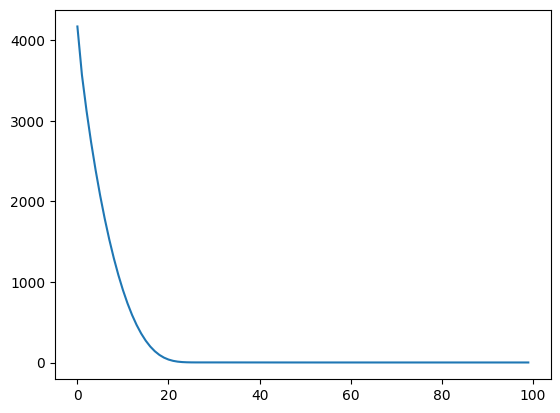

In [263]:
plt.plot(losses)
plt.show()

In [264]:
import plotly.graph_objects as go
epochs = list(range(len(losses)))

fig = go.Figure(data=go.Scatter(x=epochs, y=losses, mode='lines+markers', name='Train'))

fig.update_layout(title='Training Loss per Epoch',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')

fig.show()

## Evaluation

In [265]:
targets = [] 
predicted = []

model.eval()
for i, (x, y) in enumerate(test_loader):
    h_s = model.init_h(x.shape[0], x.shape[1]).to(device) 
        
    x = x.to(device)
    y = y.to(device)
    y_pred, h_out = model(x, h_s)
    y_pred = y_pred[:, -1, :]
    predicted.append(y_pred.cpu().detach().numpy())
    targets.append(y.cpu().detach().numpy())
    h_s = h_out
    

In [266]:
from sklearn.metrics import mean_squared_error
target_long_array = np.concatenate(targets)
predicted_long_array = np.concatenate(predicted)

mse = mean_squared_error(target_long_array, predicted_long_array)
print(f'Mean Squared Error (MSE): {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 4.080652236938477
Root Mean Squared Error (RMSE): 2.0200624465942383


In [267]:
target_list = target_long_array.tolist()
predicted_list = predicted_long_array.tolist()

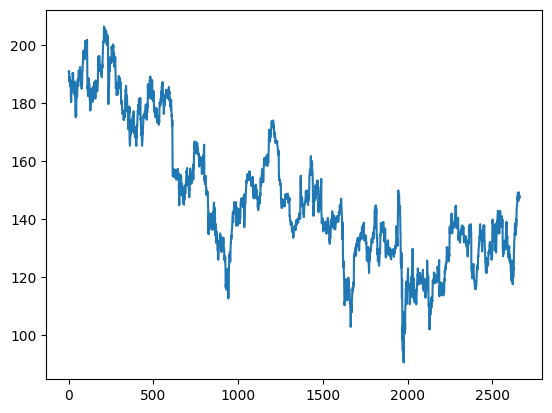

In [268]:
plt.plot(predicted_list)
plt.show()

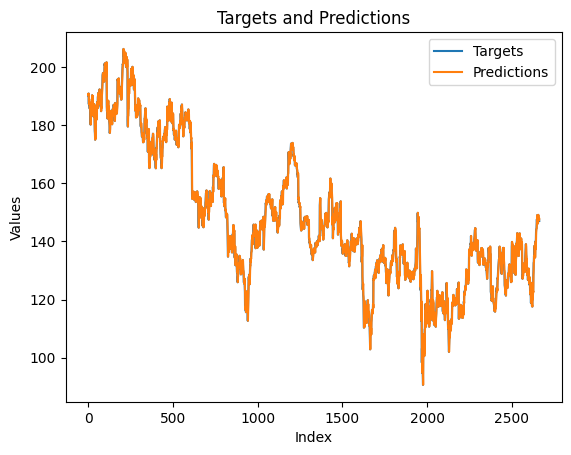

In [269]:
fig, ax = plt.subplots()

# Add the targets and predictions to the plot
ax.plot(target_list, label='Targets')
ax.plot(predicted_list, label='Predictions')

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title('Targets and Predictions')

# Add a legend
ax.legend()

# Show the plot
plt.show()